### Genaradores de imagenes

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt


c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\alvar\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [2]:
def generar_imagen(modelo, ruido_std=1.0, mostrar=False):
    """
    Genera una imagen usando un modelo.

    Parámetros:
    -----------
    modelo : keras.Model
        Modelo generativo (decoder o similar).
    ruido_std : float
        Desviación estándar del vector latente (ajusta la variabilidad).
    mostrar : bool
        Si es True, muestra la imagen con matplotlib.

    Devuelve:
    ----------
    np.ndarray : imagen generada (height, width, 3)
    """

    # Obtener la forma del espacio latente del modelo
    latent_shape = modelo.input_shape[1:]

    # Crear vector latente aleatorio
    z = np.random.normal(loc=0.0, scale=ruido_std, size=(1, *latent_shape))

    # Generar imagen
    imagen = modelo.predict(z, verbose=0)[0]

    # Recortar valores fuera de rango [0, 1]
    imagen = np.clip(imagen, 0, 1)

    # Mostrar opcionalmente
    if mostrar:
        plt.imshow(imagen)
        plt.axis("off")
        plt.show()

    return imagen

In [3]:
def generar_cuadricula(modelo, ruido_std=1.0):
    """
    Genera 6 imágenes aleatorias usando el modelo y las muestra.

    Parámetros:
    -----------
    modelo : keras.Model
        Modelo generativo (decoder).
    ruido_std : float
        Desviación estándar del vector latente.
    """
    n_imgs = 6
    imgs = []

    # Obtener forma del espacio latente
    latent_shape = modelo.input_shape[1:]

    # Generar y almacenar cada imagen
    for _ in range(n_imgs):
        z = np.random.normal(loc=0.0, scale=ruido_std, size=(1, *latent_shape))
        img = modelo.predict(z, verbose=0)[0]
        img = np.clip(img, 0, 1)
        imgs.append(img)

    # Visualizar en cuadrícula 3x2
    fig, axs = plt.subplots(2,3, figsize=(8,8))  # ancho x alto en pulgadas
    axs = axs.flatten()  # para iterar fácilmente

    for ax, img in zip(axs, imgs):
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
def recortar_modelo(modelo, desde, hasta=None):
    """
    Crea un submodelo Keras desde la capa `desde` hasta `hasta` (opcional).
    Genera un modelo independiente que comienza en la salida de `desde`.
    """
    capas = modelo.layers
    if hasta is None:
        hasta = len(capas)

    # Definir la nueva entrada a partir de la salida de la capa `desde`
    new_input = keras.Input(shape=capas[desde].output.shape[1:])

    # Pasar por las capas siguientes
    x = new_input
    for layer in capas[desde+1:hasta]:
        x = layer(x)

    # Crear submodelo independiente
    submodelo = keras.Model(inputs=new_input, outputs=x)
    return submodelo

#### AE

In [ ]:
# --- 1. Cargar el modelo decoder ---
decoder = load_model("autoencoder_decoder_v2_10_14_17_48.keras")

# --- 2. Inspeccionar las capas ---
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 3)      │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,509,731 (5.76 MB)

 Trainable params: 1,508,739 (5.76 MB)

 Non-trainable params: 992 (3.88 KB)

In [19]:
# --- 1. Cargar el modelo completo ---
ae = load_model("autoencoder_v2_10_14_17_54.keras")

# --- 2. Inspeccionar las capas ---
ae.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 512)            │       919,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │     1,509,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,283,403 (27.78 MB)

 Trainable params: 2,427,139 (9.26 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 4,854,280 (18.52 MB)

In [24]:
# Supongamos que 'autoencoder' es tu modelo completo
encoder = ae.get_layer('encoder')

# Si quieres un modelo que vaya de la entrada a la salida del encoder:
from tensorflow.keras import Model
input_layer = ae.input  # tu input original (64,64,3)
encoded_output = encoder(input_layer)
encoder_model = Model(inputs=input_layer, outputs=encoded_output)

# Ahora puedes usarlo
import numpy as np
sample_input = np.random.rand(1, 64, 64, 3).astype('float32')
embedding = encoder_model.predict(sample_input)
print(embedding.shape)  # Debería ser (1, 512)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
(1, 512)


In [31]:
for i, layer in enumerate(autoencoder.layers):
    print(i, layer.name, layer.__class__.__name__)


0 input_layer InputLayer
1 conv2d Conv2D
2 batch_normalization BatchNormalization
3 activation Activation
4 conv2d_1 Conv2D
5 batch_normalization_1 BatchNormalization
6 activation_1 Activation
7 conv2d_2 Conv2D
8 batch_normalization_2 BatchNormalization
9 activation_2 Activation
10 conv2d_3 Conv2D
11 batch_normalization_3 BatchNormalization
12 activation_3 Activation
13 conv2d_4 Conv2D
14 batch_normalization_4 BatchNormalization
15 activation_4 Activation
16 conv2d_transpose Conv2DTranspose
17 batch_normalization_5 BatchNormalization
18 activation_5 Activation
19 conv2d_transpose_1 Conv2DTranspose
20 batch_normalization_6 BatchNormalization
21 activation_6 Activation
22 conv2d_transpose_2 Conv2DTranspose
23 batch_normalization_7 BatchNormalization
24 activation_7 Activation
25 conv2d_transpose_3 Conv2DTranspose
26 batch_normalization_8 BatchNormalization
27 activation_8 Activation
28 conv2d_transpose_4 Conv2DTranspose
29 batch_normalization_9 BatchNormalization
30 activation_9 Activati

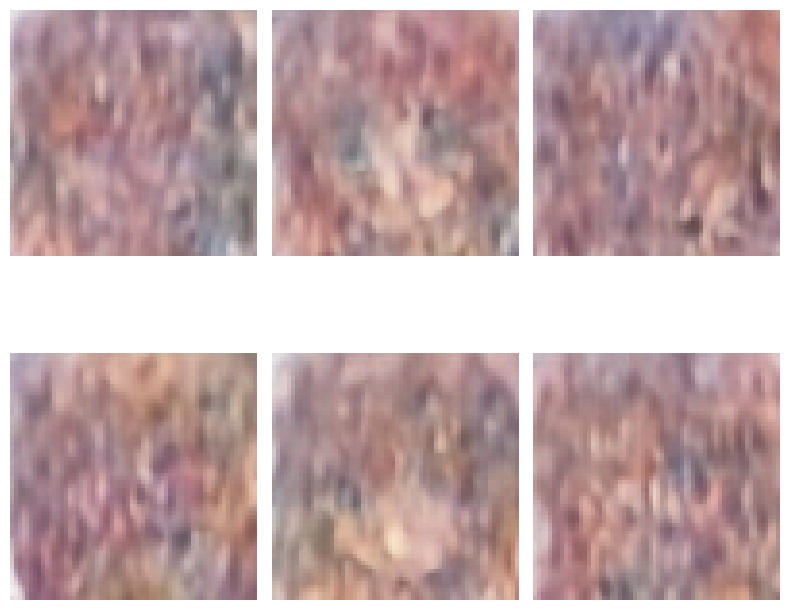

In [17]:
generar_cuadricula(decoder, ruido_std=1.0)


#### VAE

In [41]:
# --- 1. Cargar el modelo completo ---
variational_autoencoder = load_model("VAE_10_11_15_38.keras")
# --- 2. Inspeccionar las capas ---
variational_autoencoder.summary()


TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'mse', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Could not locate class 'Sampling'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'Sampling', 'config': {'name': 'sampling', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 137947052853008}}, 'registered_name': 'Sampling', 'build_config': {'input_shape': [[None, 1024], [None, 1024]]}, 'name': 'sampling', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1024], 'dtype': 'float32', 'keras_history': ['mu', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 1024], 'dtype': 'float32', 'keras_history': ['log_var', 0, 0]}}]], 'kwargs': {}}]}

In [ ]:
for i, layer in enumerate(autoencoder.layers):
    print(i, layer.name, layer.__class__.__name__)


0 input_layer InputLayer
1 conv2d Conv2D
2 batch_normalization BatchNormalization
3 activation Activation
4 conv2d_1 Conv2D
5 batch_normalization_1 BatchNormalization
6 activation_1 Activation
7 conv2d_2 Conv2D
8 batch_normalization_2 BatchNormalization
9 activation_2 Activation
10 conv2d_3 Conv2D
11 batch_normalization_3 BatchNormalization
12 activation_3 Activation
13 conv2d_4 Conv2D
14 batch_normalization_4 BatchNormalization
15 activation_4 Activation
16 conv2d_transpose Conv2DTranspose
17 batch_normalization_5 BatchNormalization
18 activation_5 Activation
19 conv2d_transpose_1 Conv2DTranspose
20 batch_normalization_6 BatchNormalization
21 activation_6 Activation
22 conv2d_transpose_2 Conv2DTranspose
23 batch_normalization_7 BatchNormalization
24 activation_7 Activation
25 conv2d_transpose_3 Conv2DTranspose
26 batch_normalization_8 BatchNormalization
27 activation_8 Activation
28 conv2d_transpose_4 Conv2DTranspose
29 batch_normalization_9 BatchNormalization
30 activation_9 Activati

In [ ]:
decoder = recortar_modelo(variational_autoencoder, desde=15)
decoder.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 3)      │           435 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 984,419 (3.76 MB)

 Trainable params: 983,427 (3.75 MB)

 Non-trainable params: 992 (3.88 KB)

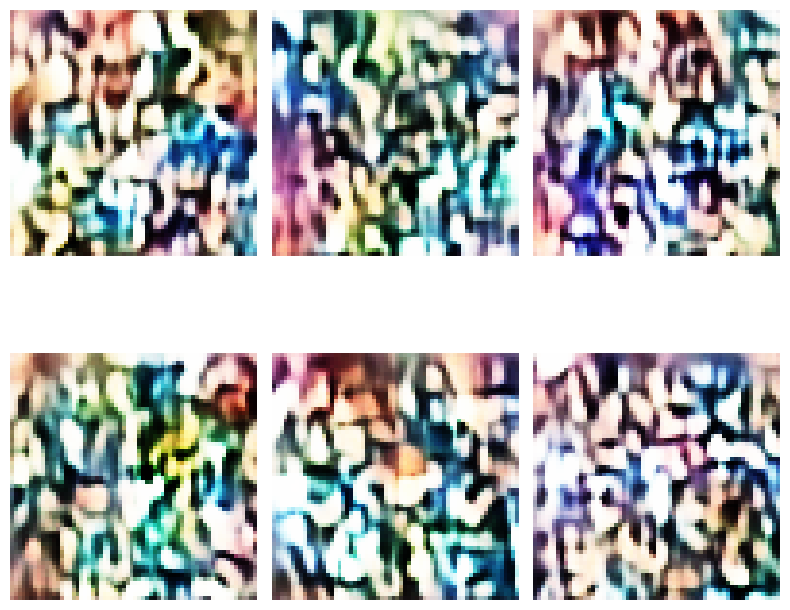

In [ ]:
generar_cuadricula(decoder, ruido_std=1.)
